#Barge Detection in the Amazon River
## Baseline CNN

Harvard CS 288 Spring 2021  
Eric Lin, Julian Lee, Maggie Wang, and Sayak Maity  
Dr. Milind Tambe and Teaching Fellows 

In [1]:
'''
Imports
'''
import torch
import torchvision
from torchvision import datasets, transforms
import math
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import numpy as np
# CNN model imports
import torch.nn as nn

# optimizer
import torch.optim as optim

import copy

'''
Parameters
'''
batch_size = 64
classes = ('negative','positive')

# Connect to GDrive

In [2]:
'''
Helpful for accessing datasets in google drive
'''

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
'''
  Navigate to the correct file path for images
'''
import os
print(os.getcwd())
# Eric filepath
# %cd "drive/.shortcut-targets-by-id/1S13RYrRLLEouppBjgNu5sSaSlLkN2pnL/Images/" 
%cd "drive/.shortcut-targets-by-id/10UbvXdBT9dp36B7zDPrVinGdcuexM8E6/CS 288 Final Project/Implementation/"
! ls

/content
/content/drive/.shortcut-targets-by-id/10UbvXdBT9dp36B7zDPrVinGdcuexM8E6/CS 288 Final Project/Implementation
288_barge_detection_cnn_v1.ipynb
288_contrastive_learning.ipynb
288_transfer_learning_barge_detection_eric_3.ipynb
288_transfer_learning_barge_detection_eric.ipynb
288_transfer_learning_barge_detection_julian.ipynb
apex
baseline_CNN_barge_detection.ipynb
datasets
graphs
masati_images
planet_images_png
runs
save
saved_models
sayak_test.ipynb
setup.sh
supContrast
test_images
tiff_to_png_script.ipynb
v2_288_transfer_learning_barge_detection_eric.ipynb
v3_288_transfer_learning_barge_detection_eric.ipynb


# Dataset
Planet satellite imagery

In [4]:
# Planet lab dataset (self curated)
# Images are 224 x 224 pixels
# Relevant no boat labels: 
# Relevant yes boat labels: 

'''
Parameters
'''
batch_size = 8
classes = ('negative', 'positive')

'''
  [change] add data augmentation as necessary
'''

transform_rgb_224 = {
    'train': transforms.Compose([
      transforms.RandomCrop((224,224)),       
      transforms.RandomHorizontalFlip(),      
      transforms.RandomVerticalFlip(),
      transforms.ColorJitter(brightness =(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=0.1),
      transforms.RandomRotation(40),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]),
    'val_test': transforms.Compose([          # no random flip
      transforms.Resize((224)),               # resize to 256
      transforms.CenterCrop(224),       # random crop to (224, 224)
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
}

# Use ImageFolder since each class of images are stored in two different folders
no_boat_folder = './planet_images_png/negative_png'          # 100 total
yes_boat_folder = './planet_images_png/positive_png'         # 100 total
dataset_planet = datasets.ImageFolder(root='planet_images_png/')
print("total length of dataset:", len(dataset_planet))

class MyLazyDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        if self.transform:
            if self.dataset[index][0].size[0] < 224 or self.dataset[index][0].size[1] < 224:
                x = self.transform(transforms.Resize(224)(self.dataset[index][0]))
            else:
                x = self.transform(self.dataset[index][0])
        else:
            x = self.dataset[index][0]
        y = self.dataset[index][1]
        return x, y
    
    def __len__(self):
        return len(self.dataset)

traindataset = MyLazyDataset(dataset=dataset_planet,transform=transform_rgb_224['train'])
validdataset = MyLazyDataset(dataset=dataset_planet, transform=transform_rgb_224['val_test'])
testdataset = MyLazyDataset(dataset=dataset_planet, transform=transform_rgb_224['val_test'])

total length of dataset: 296


In [5]:
from sklearn.model_selection import StratifiedKFold, train_test_split


# Create the index splits for training, validation and test
targets = np.array(dataset_planet.targets)
indices = np.arange(len(targets))

trainval_index, test_index = train_test_split(
  indices,
  test_size= 1 / 5,
  shuffle=True,
  stratify=targets,
  random_state=229)

test_set_planet = torch.utils.data.Subset(testdataset, indices=test_index)
testloader_planet = torch.utils.data.DataLoader(test_set_planet, batch_size=batch_size,
                                      shuffle=True, num_workers=0, drop_last=False)

skf = StratifiedKFold(n_splits = 4, shuffle=True, random_state=229)

In [6]:
print(len(trainval_index), len(test_index))

236 60


In [ ]:
# # Plant lab dataset (self curated)
# # Images are 224 x 224 pixels
# # Relevant no boat labels: 
# # Relevant yes boat labels: 

# '''
# Parameters
# '''
# batch_size = 8
# classes = ('negative', 'positive')

# '''
#   [change] add data augmentation as necessary
# '''
# transform_rgb_224 = {
#     'train': transforms.Compose([
#       transforms.RandomCrop((224,224)),       # random crop to (224, 224)
#       transforms.RandomHorizontalFlip(),      # random flip
#       transforms.ToTensor(),
#       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ]),
#     'val_test': transforms.Compose([          # no random flip
#       transforms.Resize((224)),               # resize to 224
#       transforms.CenterCrop(224),       # random crop to (224, 224)
#       transforms.ToTensor(),
#       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
#     ])
# }

# # [change] adapt to our custom data

# # Use ImageFolder since each class of images are stored in two different folders
# no_boat_folder = 'planet_images_png/negative_png'          # 100 total
# yes_boat_folder = 'planet_images_png/positive_png'         # 100 total
# dataset_planet = datasets.ImageFolder(root='planet_images_png/')
# print("total length of dataset:", len(dataset_planet))
# # Randomly split data with 80/20 split

# class MyLazyDataset(torch.utils.data.Dataset):
#     def __init__(self, dataset, transform=None):
#         self.dataset = dataset
#         self.transform = transform

#     def __getitem__(self, index):
#         if self.transform:
#             if self.dataset[index][0].size[0] < 224 or self.dataset[index][0].size[1] < 224:
#                 x = self.transform(transforms.Resize(224)(self.dataset[index][0]))
#             else:
#                 x = self.transform(self.dataset[index][0])
#         else:
#             x = self.dataset[index][0]
#         y = self.dataset[index][1]
#         return x, y
    
#     def __len__(self):
#         return len(self.dataset)

# traindataset = MyLazyDataset(dataset_planet,transform_rgb_224['train'])
# validdataset = MyLazyDataset(dataset_planet, transform_rgb_224['val_test'])
# testdataset = MyLazyDataset(dataset_planet, transform_rgb_224['val_test'])

# # Create the index splits for training, validation and test
# train_size = 0.6
# num_train = len(dataset_planet)
# indices = list(range(num_train))
# split = int(np.floor(train_size * num_train))
# split2 = int(np.floor((train_size+(1-train_size)/2) * num_train))
# np.random.seed(213452)
# np.random.shuffle(indices)
# train_idx, valid_idx, test_idx = indices[:split], indices[split:split2],indices[split2:]

# train_set_planet = torch.utils.data.Subset(traindataset, indices=train_idx)
# valid_set_planet = torch.utils.data.Subset(validdataset, indices=valid_idx)
# test_set_planet = torch.utils.data.Subset(testdataset, indices=test_idx)


# print("train:", len(train_set_planet), "validate:", len(valid_set_planet), "test:", len(test_set_planet))

# # Data loaders
# trainloader_planet = torch.utils.data.DataLoader(train_set_planet, batch_size=batch_size,
#                                           shuffle=True, num_workers=2, drop_last=True)
# validloader_planet = torch.utils.data.DataLoader(valid_set_planet, batch_size=batch_size,
#                                           shuffle=False, num_workers=2, drop_last=True)
# testloader_planet = torch.utils.data.DataLoader(test_set_planet, batch_size=batch_size,
#                                          shuffle=False, num_workers=2, drop_last=True)


total length of dataset: 203
train: 121 validate: 41 test: 41


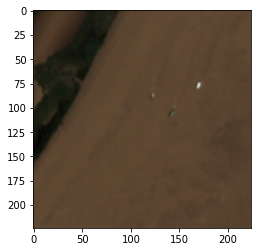

tensor(1)


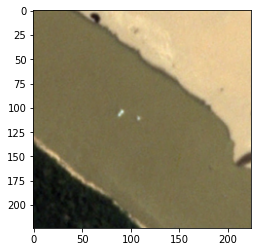

tensor(1)


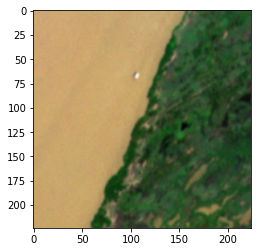

tensor(1)


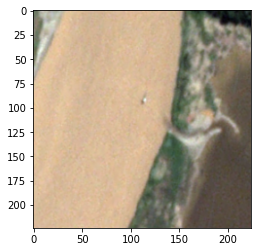

tensor(1)


In [78]:
# Check and see images for datasets
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(testloader_planet)
images, labels = dataiter.next()

for j in range(0,8):
  if torch.eq(labels[j],1):
      imshow(images[j])
      print(labels[j])

# Training

In [11]:
# Definitions for train, validate, and test
def validate(net, epoch, validloader, pos_weight=1.5):
    criterion = nn.CrossEntropyLoss()
    correct = 0
    counter = 0
    total = 0
    running_loss = 0.0
    net.eval()      # turn on eval mode

    with torch.no_grad():
        criterion = nn.CrossEntropyLoss(weight = torch.Tensor([1.0, pos_weight]).cuda())

        for (images, labels) in validloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            counter += 1
            correct += (predicted == labels).sum().item()

            loss = criterion(outputs, labels)
            running_loss += loss.item()

    print('Epoch %d Validation accuracy: %d%% loss: %f' % (
        epoch + 1, 100 * correct / total, running_loss / counter))
    
    return running_loss / counter

def train(net, epochs, trainloader, validloader, testloader, optimizer, batch_size, validation=False, early_stopping = 6, transfer=True, classes=classes, pos_weight=1.5):
    best_accuracy = 0
    lowest_loss = 10
    epochs_no_improve = 0

    for epoch in range(epochs):  # loop over the dataset multiple times
        # criterion = nn.CrossEntropyLoss()
        criterion = nn.CrossEntropyLoss(weight = torch.Tensor([1.0, pos_weight]).cuda())
        net.train()     # turn on train mode after eval
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        counter = 0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.cuda(), labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            # accuracy
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            running_total += labels.size(0)
            counter += 1
            running_correct += (predicted == labels).sum().item()
          
            if i % 5 == 0:
                running_acc = '%.2f' % (running_correct * 1.0 / running_total)
                running_loss = '%.3f' % (running_loss / counter)
                # print('[Epoch %d, %2d] training loss: %.3f' %(epoch + 1, i + 1, running_loss))
                # print(i, 'running_correct', running_correct, 'running_loss', running_loss, 'running_total', running_total, 'counter', counter, labels.size(0))
                print(f'{epoch} \t {i} \t {running_loss} \t {running_acc}')
                running_loss = 0.0
                running_correct = 0
                running_total = 0
                counter = 0

        loss = validate(net, epoch, validloader)
        # if accuracy > best_accuracy:
        #     best_accuracy = accuracy
            # if transfer:
            #   SAVE_PATH = './saved_models/resnet18-trial-3-postTL.pth'
            # else:
            #   SAVE_PATH = './saved_models/resnet18-base.pth'
            # state = {
            #     'epoch': epochs,
            #     'state_dict': net.state_dict(),
            #     'optimizer': optimizer.state_dict()
            # }
            # torch.save(state, SAVE_PATH)   # saves state dicts
        if loss < lowest_loss:
            lowest_loss = loss
            epochs_no_improve = 0 
        else:
            epochs_no_improve += 1 
        
        if epochs_no_improve == early_stopping: 
            print('Early Stopping with', early_stopping, "epochs of no improvement.")
            return test(net, testloader, classes, batch_size)

    return test(net, testloader, classes, batch_size)


def test(net, testloader, classes, batch_size):
    criterion = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    class_correct = list(0. for i in range(len(classes)))
    class_total = list(0. for i in range(len(classes)))
    net.eval()
    with torch.no_grad():
        for (images, labels) in testloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Accuracy by class
            c = (predicted == labels).squeeze()
            for i in range(min(batch_size, len(labels))):
                label = labels[i]
                if min(batch_size, len(labels)) > 1:
                    class_correct[label] += c[i].item()
                else:
                    class_correct[label] += c
                class_total[label] += 1

    print('Accuracy on test images: %d%%' % (
        100 * correct / total))      
    # Accuracy for each class
    for i in range(2):
        print('Accuracy of %1s : %2d%%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
        
    return [
        (100 * correct / total), 
        (100 * class_correct[0] / class_total[0]),
        (100 * class_correct[1] / class_total[1])
    ]


# Baseline model

In [8]:
# baseline CNN (custom) model
# modeled after classifier in "Ship Classification and Detection Based on CNN Using GF-3 SAR Images" 
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,
               padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

class ConvNetBaseline(nn.Module):
    def __init__(self):
        super(ConvNetBaseline, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),                # rgb channel input
            conv_block(32, 32),
            conv_block(32, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 128),
            conv_block(128, 128),
            conv_block(128, 128),
            conv_block(128, 128),
            conv_block(128, 128),
            nn.AdaptiveAvgPool2d(1)
        )
        # FC layer
        self.classifier = nn.Linear(128, len(classes))   # 128 in_features, binary output

    def forward(self, x):
        h = self.model(x)
        B, C, _, _ = h.shape
        h = h.view(B, C)
        return self.classifier(h)

# Training

In [14]:
# Training
import torch.optim as optim

test_accuracies_lst = []

for train_index, val_index in skf.split(trainval_index, targets[trainval_index]):
    model_baseline = ConvNetBaseline().cuda()    # use gpu
    lr = 0.005
    epochs = 30

    # Loss function and optimizer
    

    optimizer = optim.Adam(model_baseline.parameters(), lr=lr)
    # optimizer = optim.SGD(model_baseline.parameters(), lr=lr, momentum=0.7, weight_decay=5e-4)

    train_set_planet = torch.utils.data.Subset(traindataset, indices=trainval_index[train_index])
    valid_set_planet = torch.utils.data.Subset(validdataset, indices=trainval_index[val_index])  

    trainloader_planet = torch.utils.data.DataLoader(train_set_planet, batch_size=batch_size,
                                              shuffle=True, num_workers=0, drop_last=False)
    validloader_planet = torch.utils.data.DataLoader(valid_set_planet, batch_size=batch_size,
                                              shuffle=True, num_workers=0, drop_last=False)

    print('Train:', len(train_set_planet), 'Validation:', len(valid_set_planet), 'Test:', len(test_set_planet))
      

    test_accuracies_lst.append(train(model_baseline, epochs=epochs, trainloader=trainloader_planet, validloader=validloader_planet, testloader=testloader_planet, optimizer=optimizer, batch_size=batch_size, validation=True, early_stopping = 10, transfer=True, classes=classes, pos_weight=1.0))

Train: 177 Validation: 59 Test: 60
0 	 0 	 0.643 	 0.75
0 	 5 	 0.545 	 0.75
0 	 10 	 0.816 	 0.68
0 	 15 	 0.475 	 0.68
0 	 20 	 0.582 	 0.60
Epoch 1 Validation accuracy: 71% loss: 1.691118
1 	 0 	 1.127 	 0.62
1 	 5 	 0.597 	 0.72
1 	 10 	 0.559 	 0.68
1 	 15 	 0.705 	 0.75
1 	 20 	 0.509 	 0.68
Epoch 2 Validation accuracy: 66% loss: 0.525018
2 	 0 	 0.751 	 0.62
2 	 5 	 0.453 	 0.70
2 	 10 	 0.391 	 0.72
2 	 15 	 0.474 	 0.65
2 	 20 	 0.799 	 0.72
Epoch 3 Validation accuracy: 62% loss: 0.571999
3 	 0 	 0.305 	 1.00
3 	 5 	 0.556 	 0.80
3 	 10 	 0.558 	 0.80
3 	 15 	 0.456 	 0.80
3 	 20 	 0.548 	 0.80
Epoch 4 Validation accuracy: 64% loss: 0.968528
4 	 0 	 0.341 	 0.88
4 	 5 	 0.467 	 0.72
4 	 10 	 0.605 	 0.72
4 	 15 	 0.507 	 0.82
4 	 20 	 0.428 	 0.90
Epoch 5 Validation accuracy: 74% loss: 0.499300
5 	 0 	 0.436 	 0.88
5 	 5 	 0.430 	 0.88
5 	 10 	 0.445 	 0.82
5 	 15 	 0.577 	 0.72
5 	 20 	 0.532 	 0.72
Epoch 6 Validation accuracy: 76% loss: 0.439649
6 	 0 	 0.500 	 0.62
6 	 5 	 

In [ ]:
test(model_baseline, testloader_planet, classes=classes, batch_size=batch_size)

Accuracy on test images: 70%
Accuracy of negative : 60%
Accuracy of positive : 80%


In [ ]:
SAVE_PATH = './saved_models/baseline_no_pretraining_v1.pth'
state = {
    'epoch': epochs,
    'state_dict': model_baseline.state_dict(),
    'optimizer': optimizer.state_dict()
}
torch.save(state, SAVE_PATH)   # saves state dicts
# torch.save(net, SAVE_PATH)                  # saves whole model